In [51]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import asyncio
from tardis_client import TardisClient, Channel
from sklearn.preprocessing import StandardScaler
from skl2onnx.common.data_types import FloatTensorType
from sklearn.pipeline import Pipeline
import csv
from sklearn.model_selection import train_test_split
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
import onnxruntime as rt
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
from sklearn.linear_model import Lasso
import onnx

In [2]:
async def kraken(symbol, start_date, end_date):
    data = []
    tardis_client = TardisClient(api_key='REDACTED')

    messages = tardis_client.replay(
        exchange="kraken",
        from_date=start_date,
        to_date=end_date,
        filters=[Channel(name="spread", symbols=[symbol])],
    )
    
    async for local_timestamp, message in messages:
        timestamp = float(message[1][2])
        bid = float(message[1][0])
        ask = float(message[1][1])
        mid = (bid + ask) / 2
        spread = abs(ask-bid) / mid
        data.append([timestamp, mid, spread])
    return data

data = sorted(await kraken("ETH/USDT", "2022-11-09", "2022-11-12"), key=lambda x: x[0])

In [3]:
raw_df = pd.DataFrame(data, columns =['timestamp', 'price', 'spread'], dtype = float).sort_values(by=['timestamp'])    

In [4]:
i = 1
price_sum = data[0][1]
spread_sum = data[0][2]
count = 1
timestamp = data[0][0]
processed_data = []
while i < len(data):
    if (data[i][0] - timestamp > 12):
        processed_data.append([timestamp, price_sum/count, spread_sum/count])
        timestamp = data[i][0]
        price_sum = data[i][1]
        spread_sum = data[i][2]
        count = 1
    else:
        count += 1
        price_sum += data[i][1]
        spread_sum += data[i][2]
    i += 1

In [5]:
df = pd.DataFrame(processed_data, columns =['timestamp', 'price', 'spread'], dtype = float).sort_values(by=['timestamp'])    

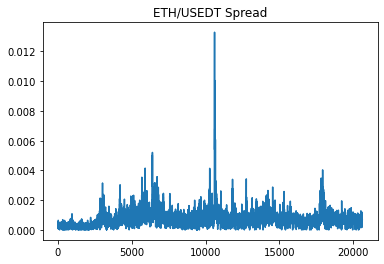

In [6]:
plt.title("ETH/USEDT Spread")
plt.plot(df['spread'])

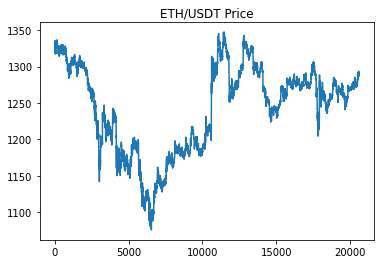

In [7]:
plt.title("ETH/USDT Price")
plt.plot(df['price'])

In [8]:
df.head()

,timestamp,price,spread
0,1.667952e+09,1333.525520,0.000289
1,1.667952e+09,1332.740106,0.000265
2,1.667952e+09,1333.968009,0.000366
3,1.667952e+09,1335.444956,0.000369
4,1.667952e+09,1335.696943,0.000381


In [9]:
df.describe()

,timestamp,price,spread
count,2.061400e+04,20614.000000,20614.000000
mean,1.668083e+09,1242.347283,0.000805
std,7.454113e+04,59.712744,0.000502
min,1.667952e+09,1075.895615,0.000008
25%,1.668020e+09,1190.746226,0.000540
50%,1.668083e+09,1259.906613,0.000733
75%,1.668147e+09,1288.547117,0.000963
max,1.668211e+09,1347.166567,0.013284


In [10]:
windows = [5, 10, 20]
for w in windows:
    df['vol_' + str(w) + 'b'] = df['price'].rolling(w).std() / df['price']
    df['spread_' + str(w) + 'b'] = df['spread'].rolling(w).mean()
df = df.dropna()

In [11]:
X = df[['vol_5b','vol_10b','vol_20b']]
y = df['spread_5b']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
model = XGBRegressor(n_estimators = 150, random_state = 0, learning_rate = 0.1, max_depth=13)
model.fit(X_train.values, y_train.values)
print("Score = " + str(model.score(X_test.values, y_test.values)))

[21:19:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score = 0.4138475787380421


In [13]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb', XGBRegressor(n_estimators = 150, random_state = 0, learning_rate = 0.1, max_depth=13))])
pipe.fit(X, y)

[21:19:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb', XGBRegressor(max_depth=13, n_estimators=150))])

In [14]:
# Convert to ONNX 
update_registered_converter(
    XGBRegressor, 'XGBRegressor',
    calculate_linear_regressor_output_shapes, convert_xgboost)

model_onnx = to_onnx(pipe, X.astype(np.float32))
with open("XGBSpreadModel.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [15]:
df.head()

,timestamp,price,spread,vol_5b,spread_5b,vol_10b,spread_10b,vol_20b,spread_20b
19,1.667952e+09,1325.861937,0.000586,0.000504,0.000489,0.001121,0.000401,0.002846,0.000343
20,1.667952e+09,1325.477406,0.000650,0.000454,0.000553,0.001114,0.000446,0.002846,0.000361
21,1.667952e+09,1325.287278,0.000649,0.000392,0.000597,0.001052,0.000479,0.002853,0.000380
22,1.667952e+09,1324.852297,0.000458,0.000357,0.000569,0.000742,0.000497,0.002784,0.000385
23,1.667952e+09,1324.969898,0.000495,0.000306,0.000568,0.000465,0.000506,0.002548,0.000391


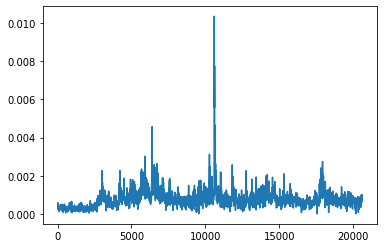

In [16]:
plt.plot(y)

In [17]:
model = XGBRegressor(n_estimators = 150, random_state = 0, learning_rate = 0.1, max_depth=13)
model.fit(X.values, y.values)

[21:19:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=13, n_estimators=150)

In [39]:
model = Lasso(alpha=0.00000003)
model.fit(X_train.values, y_train.values)
model.score(X_test.values, y_test.values)

0.3416133117300867

In [40]:
model.coef_

array([0.01052914, 0.06661054, 0.12278418])

In [26]:
model.predict(X_train.values)

array([0.00080785, 0.00066008, 0.00068259, ..., 0.00064884, 0.00075133,
       0.00095527])

In [53]:
onnx_model = convert_sklearn(model, initial_types=[("float_input", FloatTensorType([None, 3]))])

# Save the ONNX model to a file
onnx.save_model(onnx_model, "lasso.onnx")

In [42]:
X_train.shape[1]

3